In [1]:
import functools

import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [2]:
def normalize(data, lo, hi):
    return cv2.normalize(data, None, lo, hi, norm_type=cv2.NORM_MINMAX)

In [3]:
def gaussian_kernel(k, std):
    half = (k - 1) / 2
    raw_filter = sp.stats.norm.pdf(np.arange(-half, half + 1), scale=std)
    normalized = raw_filter / raw_filter.sum()
    return normalized

In [4]:
def apply_kernel(kernel, image):
    convolved = [sp.signal.convolve2d(image[..., ch], kernel, mode='same', boundary='symm')
                 for ch in range(image.shape[-1])]
    stacked = np.stack(convolved, -1)
    return stacked

In [5]:
def gaussian_blurrer(k_size, sigma):
    f = gaussian_kernel(k_size, sigma)
    kernel = np.outer(f, f)

    return functools.partial(apply_kernel, kernel)

In [6]:
def imshow(image):
    image = normalize(image, 0, 255)
    plt.imshow(cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB))

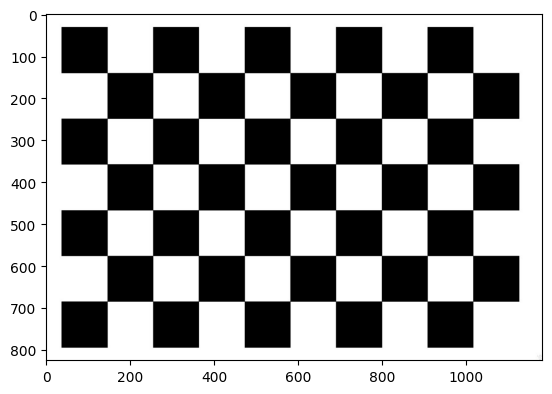

In [7]:
img = cv2.imread('chessboard-hw1.jpg')
imshow(img)

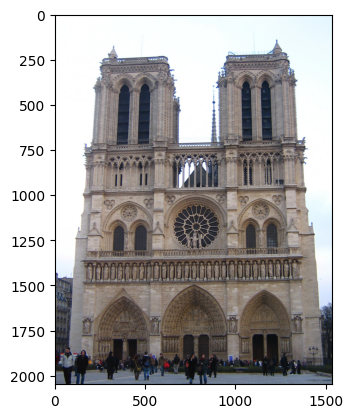

In [8]:
img2 = cv2.imread('1a_notredame.jpg')
imshow(img2)

In [9]:
blurrer5x5 = gaussian_blurrer(5, 5)
blurrer10x10 = gaussian_blurrer(10, 5)

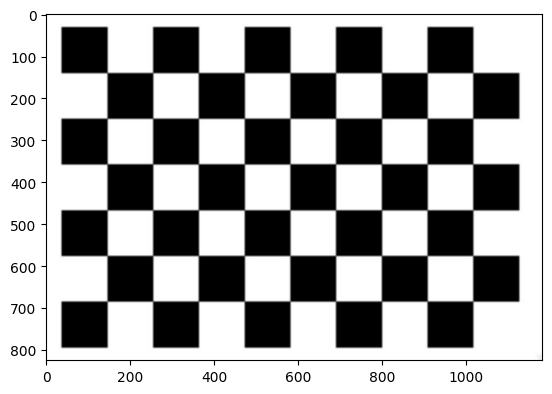

In [10]:
blurred_img5x5 = blurrer5x5(img)
imshow(blurred_img5x5)

True

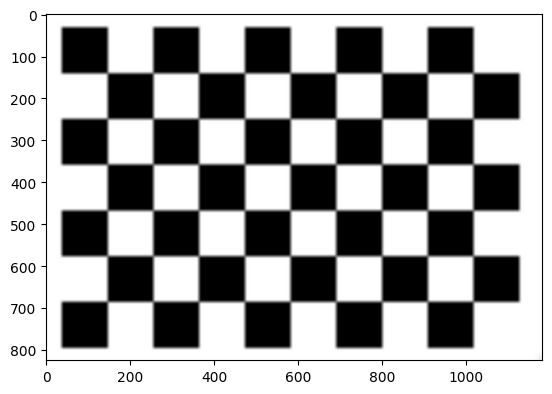

In [11]:
blurred_img10x10 = blurrer10x10(img)
imshow(blurred_img10x10)
cv2.imwrite('chessboard10x10.jpg', blurred_img10x10)

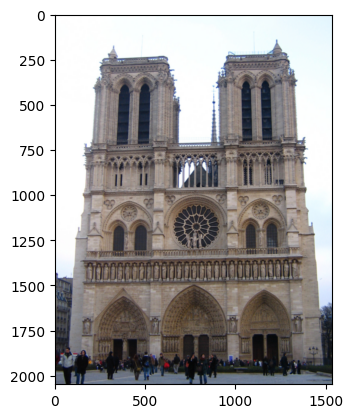

In [12]:
blurred_img25x5 = blurrer5x5(img2)
imshow(blurred_img25x5)

True

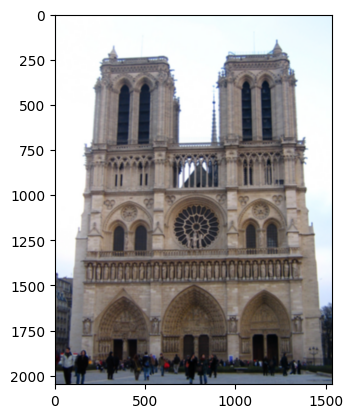

In [13]:
blurred_img210x10 = blurrer10x10(img2)
imshow(blurred_img210x10)
cv2.imwrite('blurred_img210x10.jpg', blurred_img210x10)

In [14]:
def sobel_filter():
    hx = np.array([[-1., 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
    hy = np.array([[1., 2, 1], [0, 0, 0], [-1, -2, -1]]) / 8
    return hy, hx  # since the direction is arctan(dy, dx)

In [15]:
def gradient_field(image, threshold_ratio=0):
    sobel = sobel_filter()
    image = normalize(image, 0, 1)

    gradient = [apply_kernel(s, image) for s in sobel]
    magnitude = np.hypot(*gradient)
    direction = np.arctan2(*gradient)

    threshold = magnitude.max() * threshold_ratio
    gradient[0][magnitude <= threshold] = 0.0
    gradient[1][magnitude <= threshold] = 0.0
    direction[magnitude <= threshold] = 0.0
    magnitude[magnitude <= threshold] = 0.0
    return gradient, magnitude, direction

In [16]:
def direction_in_hue(magnitude, direction):
    hsv = np.zeros(direction.shape, dtype=np.uint8)

    hsv[..., 0] = direction.mean(axis=-1) * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = normalize(magnitude.mean(axis=-1), 0, 255)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return rgb

In [17]:
def show_gradient(magnitude, direction):
    rgb = direction_in_hue(magnitude, direction)
    fig, ax = plt.subplots(1, 2, figsize=(16, 10), sharey='all')
    ax[0].imshow(normalize(magnitude, 0, 1))
    ax[1].imshow(rgb)

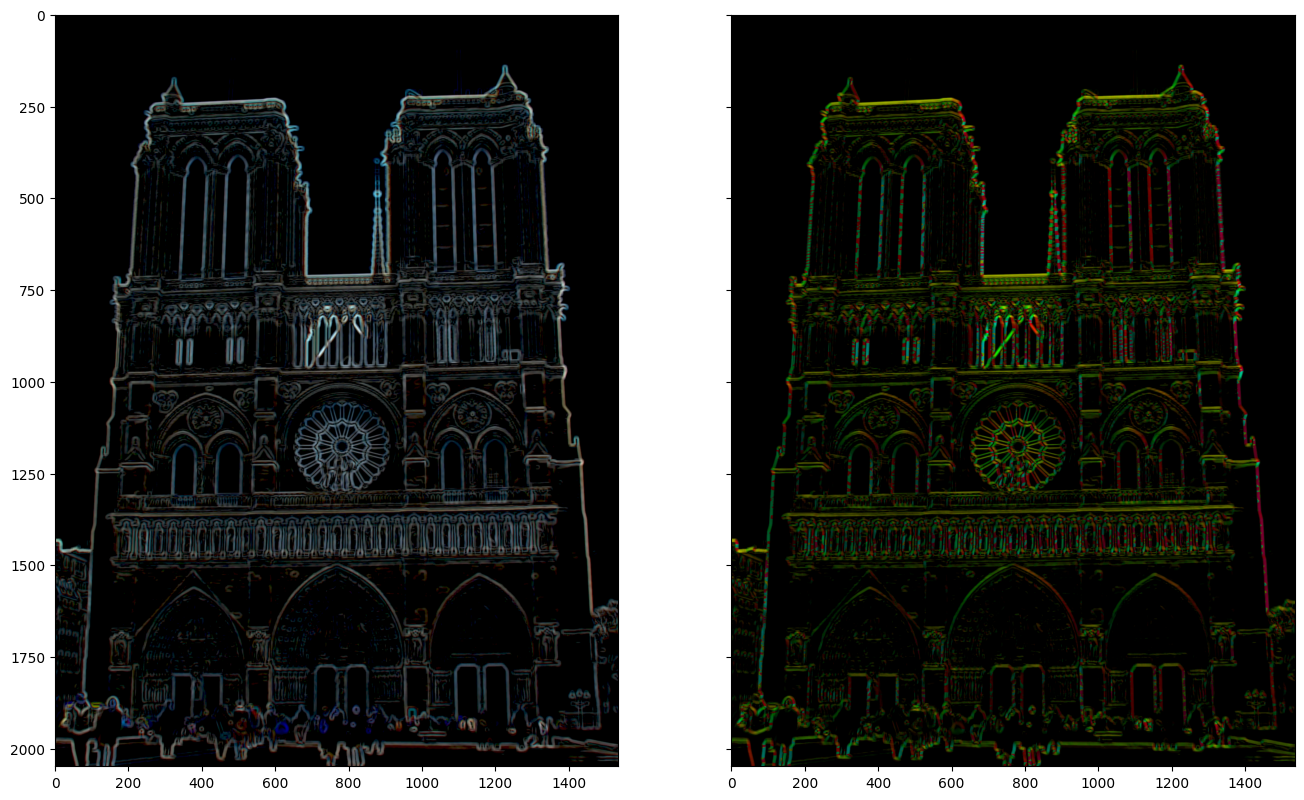

In [52]:
grad, mag, dire = gradient_field(blurred_img210x10, 0.1)
show_gradient(mag, dire)

In [19]:
# 1-3

In [20]:
def summation_kernel(size):
    k = np.ones((size, size))
    return functools.partial(apply_kernel, k)

In [21]:
def structure_tensor(gradient):
    Ixx = gradient[1] ** 2
    Ixy = gradient[0] * gradient[1]
    Iyy = gradient[0] ** 2

    return Ixx, Ixy, Iyy

In [22]:
def calc_eigen_minus(window, Ixx, Ixy, Iyy):
    Ixx = window(Ixx)
    Ixy = window(Ixy)
    Iyy = window(Iyy)

    det = Ixx * Iyy - Ixy * Ixy
    trace = Ixx + Iyy + 1e-5
    eigen_minus = det / trace
    response = det - 0.04 * (trace ** 2)
    return eigen_minus, response

In [23]:
window3x3 = summation_kernel(3)
window5x5 = summation_kernel(5)

In [53]:
Hs = structure_tensor(grad)

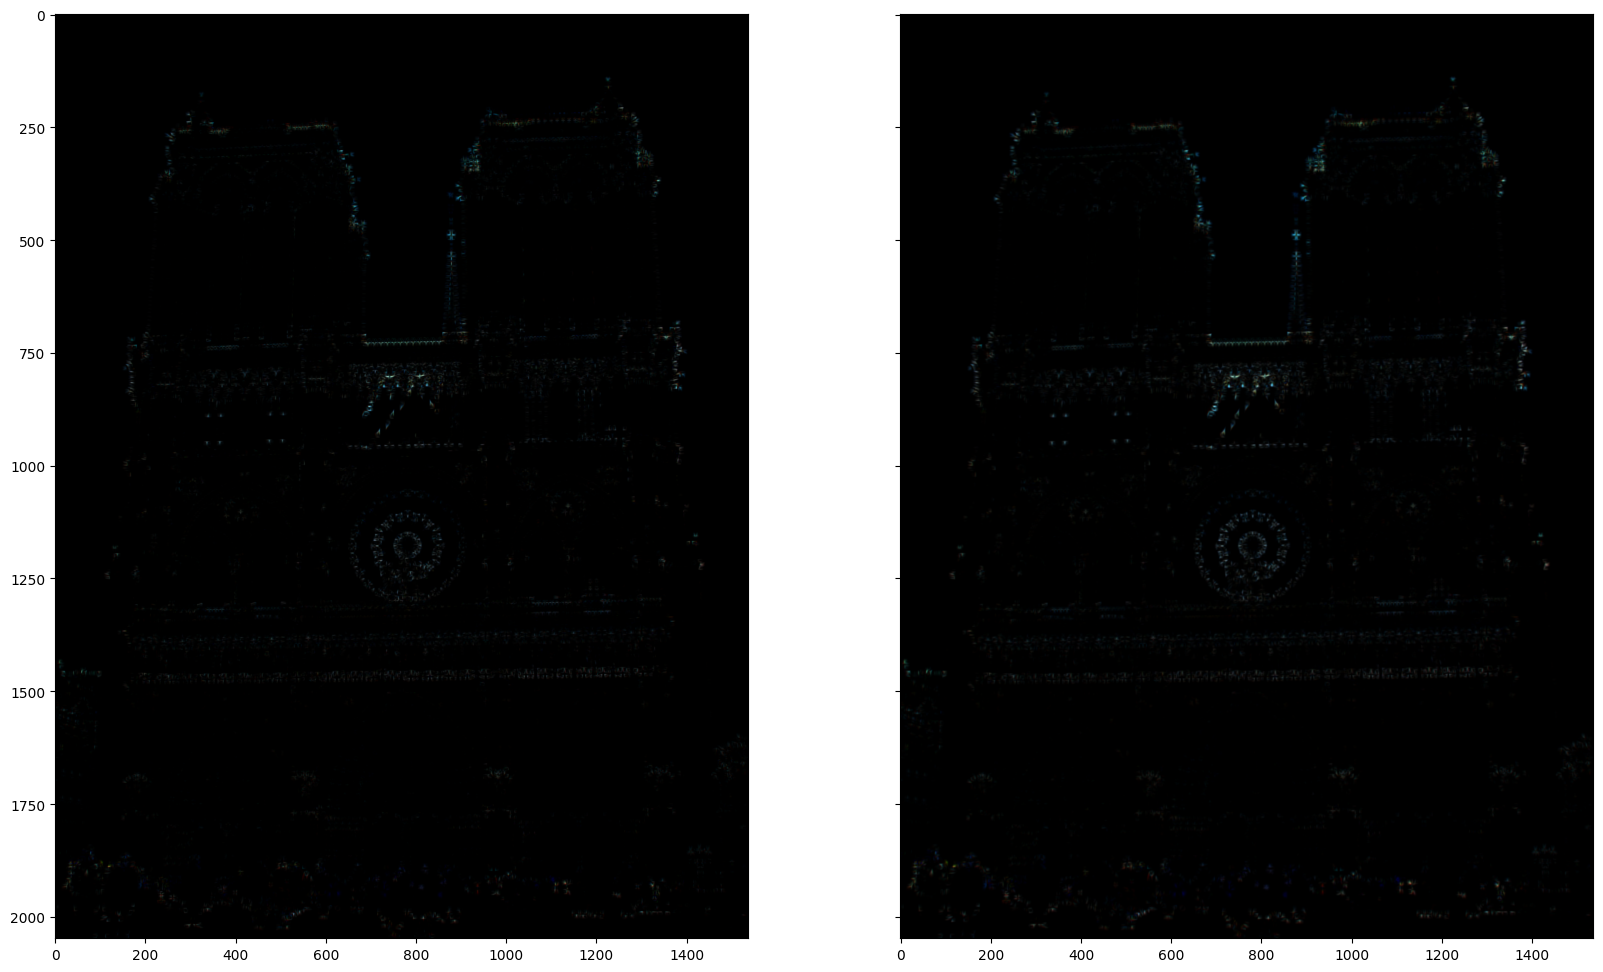

In [54]:
eigen_minus3x3, resp3x3 = calc_eigen_minus(window3x3, *Hs)
eigen_minus3x3 = normalize(eigen_minus3x3, 0, 1)

eigen_minus5x5, resp5x5 = calc_eigen_minus(window5x5, *Hs)
eigen_minus5x5 = normalize(eigen_minus5x5, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey='all')
ax[0].imshow(eigen_minus3x3)
ax[1].imshow(eigen_minus5x5)

In [26]:
# finding corner
resp3x3[resp3x3 < 0] = 0
resp5x5[resp5x5 < 0] = 0

In [27]:
# 1-4

In [120]:
def windowed_slices(idx, wr):
    x, y, ch = idx
    s = [(np.s_[max(u - wr, 0):u + wr + 1], np.s_[max(v - wr, 0):v + wr + 1], c)
         for u, v, c in zip(x, y, ch)]

    return s

In [126]:
def non_maximal_suppression(corner_map: np.ndarray, w_radius=5, threshold=1e-2):
    corner_map = corner_map.copy()
    corner_map[corner_map < threshold] = 0
    print(np.count_nonzero(corner_map))
    result = np.zeros_like(corner_map)

    flatten_cmap = corner_map.reshape([-1, corner_map.shape[-1]])

    while np.count_nonzero(corner_map) > 0:
        pos = flatten_cmap.argmax(axis=0)
        unravel_pos = *np.unravel_index(pos, corner_map.shape[:-1]), np.array([0, 1, 2], dtype=np.int64)
        neighbor_slices = windowed_slices(unravel_pos, 2)
        for n in neighbor_slices:
            result[n] = 1
        neighbor_slices = windowed_slices(unravel_pos, w_radius)
        for neighbor in neighbor_slices:
            corner_map[neighbor] = 0

    return result

In [127]:
a = non_maximal_suppression(eigen_minus5x5, 25, 0.15)

14406


True

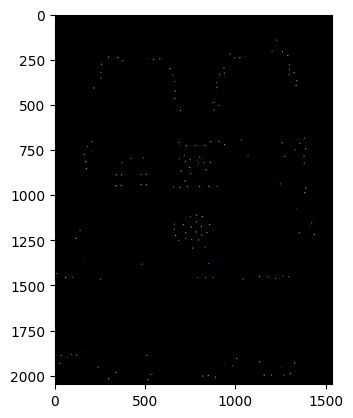

In [128]:
plt.imshow(a)
cv2.imwrite('test3.jpg', normalize(a, 0, 255))

In [119]:
# result = np.zeros_like(eigen_minus3x3)
#
# flatten_cmap = eigen_minus3x3.reshape([-1, eigen_minus3x3.shape[-1]])
# flatten_cmap.shape

(975975, 3)

In [131]:
# eigen_minus3x3.shape

(825, 1183, 3)

In [136]:
# pos = flatten_cmap.argmax(axis=0)
# unravel_pos = *np.unravel_index(pos, eigen_minus3x3.shape[:-1]), np.array([0, 1, 2], dtype=np.int64)
# pos, unravel_pos

(array([290959, 290959, 290959], dtype=int64),
 (array([245, 245, 245], dtype=int64),
  array([1124, 1124, 1124], dtype=int64),
  array([0, 1, 2], dtype=int64)))

In [139]:
# eigen_minus3x3[unravel_pos]

array([1., 1., 1.])

In [160]:
# unravel_pos

(array([245, 245, 245], dtype=int64),
 array([1124, 1124, 1124], dtype=int64),
 array([0, 1, 2], dtype=int64))

In [163]:
# windowed_slices(unravel_pos, 5)

[(slice(243, 248, None), slice(1122, 1127, None), 0),
 (slice(243, 248, None), slice(1122, 1127, None), 1),
 (slice(243, 248, None), slice(1122, 1127, None), 2)]

In [165]:
# eigen_minus3x3[_[0]]

array([[2.82932262e-18, 7.38963677e-08, 1.60194589e-07, 3.18590513e-07,
        1.13793841e-06],
       [3.32644193e-07, 2.37640900e-01, 3.54441895e-01, 3.01490242e-01,
        2.43606390e-01],
       [7.59237593e-07, 3.54485512e-01, 1.00000000e+00, 9.48295578e-01,
        8.06221094e-01],
       [1.05375794e-06, 3.01180428e-01, 9.44203148e-01, 7.19687584e-01,
        5.07947501e-01],
       [8.26691131e-07, 2.43213846e-01, 8.00141777e-01, 5.05462999e-01,
        2.41869446e-01]])